In [98]:
import random
import shutil
import time
import warnings
import sys
import torch
import torch.nn as nn
import numpy as np
import os
import pandas as pd
from PIL import Image
import torch.nn.parallel
from tqdm import tqdm
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import torch.nn.init as init

In [99]:
#dataset
class Surgical(Dataset): 

    def __init__(self, root="./datas", train=True, transform=None, video=0):
        self.train = train
        self.video = str(video)
        if(self.train):
            # Path of csvs
            Phase_path = "./datas/annotation/video_{number}.csv".format(number=self.video)
            self.phasepath = os.path.join(Phase_path)
            # Path of images
            frame_path = "./datas/{number}".format(number=self.video)
            self.root = os.path.join(frame_path)
            #video_41 is test file.
        else:
            self.phasepath = os.path.join("./datas/annotation/video_41.csv")
            self.root = os.path.join("./datas/41")
        # Transforms
        self.transform = transform
    
    def __getitem__(self, index):
        csv = pd.read_csv(self.phasepath)
        data = csv
        if index <= len(data)-2:   
            X = []       
            for i in range(index-1,index+2):    #three nearby frames
                image = Image.open(os.path.join(self.root, data.iloc[i, 0]))
                image = self.transform(image)
                X.append(image)

            y = data.iloc[index, 1]   
            X = torch.stack(X, dim=0) 
            return (X, y)

        else:
            X = []       
            for i in range(index-2,index+1):    #three nearby frames
                image = Image.open(os.path.join(self.root, data.iloc[i, 0]))
                image = self.transform(image)
                X.append(image)

            y = data.iloc[index, 1]   
            X = torch.stack(X, dim=0) 
            return (X, y)
            

    def __len__(self):
        csv = pd.read_csv(self.phasepath)
        return len(csv)


In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs =80
learning_rate = 5e-4
batch_size = 40

In [101]:
train_transform = transforms.Compose([transforms.RandomRotation(35),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(180, translate=[0.2, 0.2], scale=[0.8, 1.2]),
                                      transforms.ColorJitter(0.02, 0.02, 0.02, 0.01),
                                      transforms.RandomResizedCrop(224),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize(224),
                                     transforms.ToTensor()])


trainset_1 = Surgical(train=True, transform=train_transform, video=1)  
trainset_2 = Surgical(train=True, transform=train_transform, video=2)
trainset_3 = Surgical(train=True, transform=train_transform, video=3)
trainset_4 = Surgical(train=True, transform=train_transform, video=4)
trainset_5 = Surgical(train=True, transform=train_transform, video=5)
testset = Surgical(train=False, transform=test_transform)

In [103]:
trainloader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=batch_size,
                                          shuffle=True, pin_memory=True)
trainloader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=batch_size,
                                          shuffle=True, pin_memory=True)
trainloader_3 = torch.utils.data.DataLoader(trainset_3, batch_size=batch_size,
                                          shuffle=True, pin_memory=True)
trainloader_4 = torch.utils.data.DataLoader(trainset_4, batch_size=batch_size,
                                          shuffle=True, pin_memory=True)
trainloader_5 = torch.utils.data.DataLoader(trainset_5, batch_size=batch_size,
                                          shuffle=True, pin_memory=True)                                                                                                                                          
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, pin_memory=True)

In [104]:
# encoder using ResNet-50 pretrained
class ResCNNEncoder(nn.Module):
    def __init__(self, fc_hidden1=512, fc_hidden2=512, drop_p=0.3, CNN_embed_dim=300):
        """Load the pretrained ResNet-50 and replace top fc layer."""
        super(ResCNNEncoder, self).__init__()

        self.fc_hidden1, self.fc_hidden2 = fc_hidden1, fc_hidden2
        self.drop_p = drop_p

        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, fc_hidden1)
        self.bn1 = nn.BatchNorm1d(fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(fc_hidden1, fc_hidden2)
        self.bn2 = nn.BatchNorm1d(fc_hidden2, momentum=0.01)
        self.fc3 = nn.Linear(fc_hidden2, CNN_embed_dim)
        
    def forward(self, x_3d):
        cnn_embed_seq = []
        for t in range(x_3d.size(1)):
            # ResNet CNN
            with torch.no_grad():
                x = self.resnet(x_3d[:, t, :, :, :])  # ResNet
                x = x.view(x.size(0), -1)             # flatten output of conv

            # FC layers
            x = self.bn1(self.fc1(x))
            x = F.relu(x)
            x = self.bn2(self.fc2(x))
            x = F.relu(x)
            x = F.dropout(x, p=self.drop_p, training=self.training)
            x = self.fc3(x)

            cnn_embed_seq.append(x)

        
        cnn_embed_seq = torch.stack(cnn_embed_seq, dim=0).transpose_(0, 1)

        return cnn_embed_seq


class DecoderRNN(nn.Module):
    def __init__(self, CNN_embed_dim=300, h_RNN_layers=3, h_RNN=256, h_FC_dim=128, drop_p=0.3, num_classes=7):
        super(DecoderRNN, self).__init__()

        self.RNN_input_size = CNN_embed_dim
        self.h_RNN_layers = h_RNN_layers   # RNN hidden layers
        self.h_RNN = h_RNN                 # RNN hidden nodes
        self.h_FC_dim = h_FC_dim
        self.drop_p = drop_p
        self.num_classes = num_classes

        self.LSTM = nn.LSTM(
            input_size=self.RNN_input_size,
            hidden_size=self.h_RNN,        
            num_layers=h_RNN_layers,       
            batch_first=True,      
        )

        self.fc1 = nn.Linear(self.h_RNN, self.h_FC_dim)
        self.fc2 = nn.Linear(self.h_FC_dim, self.num_classes)

    def forward(self, x_RNN):
        
        self.LSTM.flatten_parameters()
        RNN_out, (h_n, h_c) = self.LSTM(x_RNN, None)  

        # FC layers
        x = self.fc1(RNN_out[:, -1, :])   # choose RNN_out at the last time step
        x = F.relu(x)
        x = F.dropout(x, p=self.drop_p, training=self.training)
        x = self.fc2(x)

        return x

In [106]:
CNN_fc_hidden1, CNN_fc_hidden2 = 2048, 768
CNN_embed_dim = 512   
res_size = 224        
dropout_p = 0.0       # dropout probability

# DecoderRNN architecture
RNN_hidden_layers = 3
RNN_hidden_nodes = 512
RNN_FC_dim = 256

In [107]:
cnn_encoder = ResCNNEncoder(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)
rnn_decoder = DecoderRNN(CNN_embed_dim=CNN_embed_dim, h_RNN_layers=RNN_hidden_layers, h_RNN=RNN_hidden_nodes, 
                         h_FC_dim=RNN_FC_dim, drop_p=dropout_p, num_classes=7).to(device)

In [108]:
#loss
loss_fn= nn.CrossEntropyLoss().to(device)

In [109]:
# Train 
train_Acc_list = []
train_loss_list = []
trainloader = trainloader_1
def train(model, trainloader,testloader,loss_fn, learning_rate):
    for epoch in range(1, epochs+1):
        print(f"Epoch {epoch}\n-------------------------------")
        if epoch % 10 == 0:
            learning_rate = learning_rate * 0.5
            optimizer = optim.Adam(crnn_params, learning_rate, weight_decay=1e-5)
        else:
            optimizer = optim.Adam(crnn_params, learning_rate, weight_decay=1e-5)
        cnn_encoder, rnn_decoder = model
        cnn_encoder.train()
        rnn_decoder.train()

        losses = []
        scores = []
        correct = 0
        total = 0
        
        number = epoch % 10
        if number > 5:
            number -= 5
        if number == 1:
            trainset = trainset_1
            trainloader = trainloader_1
        elif number == 2:
            trainset = trainset_2
            trainloader = trainloader_2
        elif number == 3:
            trainset = trainset_3
            trainloader = trainloader_3
        elif number == 4:
            trainset = trainset_4
            trainloader = trainloader_4
        else:
            trainset = trainset_5
            trainloader = trainloader_5
    
        N_count = 0 
        for batch_idx, (X,y) in tqdm(enumerate(trainloader)):
            X, y = X.to(device), y.to(device).view(-1, )

            N_count += X.size(0)

            optimizer.zero_grad()
            output = rnn_decoder(cnn_encoder(X))  

            loss = loss_fn(output, y)
            losses.append(loss.item())

     

            loss.backward()
            optimizer.step()
            
            _, predicted = output.max(1)

            total_batch = y.size(0)
            correct_batch = predicted.eq(y).sum().item()
            total += total_batch
            correct += correct_batch
            
        train_acc=100.0 * correct / total

        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Acc: {:.2f}%'.format(
            epoch , N_count, len(trainloader.dataset), 100. * (batch_idx + 1) / len(trainloader), loss.item(), train_acc))
  
        train_loss_list.append(losses)
        train_Acc_list.append(train_acc)
        test(model, testloader, epoch,loss_fn)
            # save all train test results

In [110]:
test_Acc_list = []
test_loss_list = []

def test(model, testloader, epoch,loss_fn) :
    cnn_encoder, rnn_decoder = model
    cnn_encoder.eval()
    rnn_decoder.eval()

    test_loss = 0
    all_y = []
    all_y_pred = []
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in testloader:
            X, y = X.to(device), y.to(device).view(-1, )

            output = rnn_decoder(cnn_encoder(X))

            loss = loss_fn(output, y)
            test_loss += loss.item()                 
            y_pred = output.max(1, keepdim=True)[1]  

            all_y.extend(y)
            all_y_pred.extend(y_pred)

    test_loss /= len(testloader.dataset)

    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())
    test_acc = 100* test_score

    print('\nTest set: Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(test_loss, test_acc))
    test_Acc_list.append(test_acc)
    test_loss_list.append(test_loss)


In [111]:
# Combine all EncoderCNN + DecoderRNN parameters
crnn_params = list(cnn_encoder.fc1.parameters()) + list(cnn_encoder.bn1.parameters()) + \
              list(cnn_encoder.fc2.parameters()) + list(cnn_encoder.bn2.parameters()) + \
              list(cnn_encoder.fc3.parameters()) + list(rnn_decoder.parameters())



In [112]:
train([cnn_encoder, rnn_decoder], trainloader,testloader,loss_fn, learning_rate)

Epoch 1
-------------------------------


11it [01:25,  7.77s/it]


Train Epoch: 1 [434/434 (100%)]	Loss: 1.290320, Acc: 33.41%

Test set: Average loss: 0.0380, Accuracy: 40.21%

Epoch 2
-------------------------------


18it [02:19,  7.73s/it]


Train Epoch: 2 [710/710 (100%)]	Loss: 1.217357, Acc: 47.89%

Test set: Average loss: 0.0382, Accuracy: 60.44%

Epoch 3
-------------------------------


37it [04:44,  7.70s/it]


Train Epoch: 3 [1458/1458 (100%)]	Loss: 0.786123, Acc: 74.42%

Test set: Average loss: 0.0408, Accuracy: 42.27%

Epoch 4
-------------------------------


10it [01:13,  7.35s/it]


Train Epoch: 4 [381/381 (100%)]	Loss: 1.576236, Acc: 45.41%

Test set: Average loss: 0.0376, Accuracy: 42.01%

Epoch 5
-------------------------------


15it [01:52,  7.53s/it]


Train Epoch: 5 [587/587 (100%)]	Loss: 0.919752, Acc: 60.99%

Test set: Average loss: 0.0761, Accuracy: 10.31%

Epoch 6
-------------------------------


11it [01:22,  7.52s/it]


Train Epoch: 6 [434/434 (100%)]	Loss: 0.942428, Acc: 62.44%

Test set: Average loss: 0.0385, Accuracy: 48.58%

Epoch 7
-------------------------------


18it [02:15,  7.53s/it]


Train Epoch: 7 [710/710 (100%)]	Loss: 0.806462, Acc: 53.66%

Test set: Average loss: 0.0401, Accuracy: 52.06%

Epoch 8
-------------------------------


37it [04:40,  7.58s/it]


Train Epoch: 8 [1458/1458 (100%)]	Loss: 0.769409, Acc: 74.35%

Test set: Average loss: 0.0496, Accuracy: 40.21%

Epoch 9
-------------------------------


10it [01:13,  7.35s/it]


Train Epoch: 9 [381/381 (100%)]	Loss: 1.176542, Acc: 48.03%

Test set: Average loss: 0.0407, Accuracy: 42.14%

Epoch 10
-------------------------------


15it [01:52,  7.51s/it]


Train Epoch: 10 [587/587 (100%)]	Loss: 0.867631, Acc: 60.99%

Test set: Average loss: 0.0378, Accuracy: 43.56%

Epoch 11
-------------------------------


11it [01:22,  7.49s/it]


Train Epoch: 11 [434/434 (100%)]	Loss: 0.967530, Acc: 58.29%

Test set: Average loss: 0.0368, Accuracy: 38.40%

Epoch 12
-------------------------------


18it [02:15,  7.51s/it]


Train Epoch: 12 [710/710 (100%)]	Loss: 1.046541, Acc: 52.82%

Test set: Average loss: 0.0522, Accuracy: 32.73%

Epoch 13
-------------------------------


37it [04:40,  7.59s/it]


Train Epoch: 13 [1458/1458 (100%)]	Loss: 0.410244, Acc: 73.05%

Test set: Average loss: 0.0319, Accuracy: 63.27%

Epoch 14
-------------------------------


10it [01:13,  7.34s/it]


Train Epoch: 14 [381/381 (100%)]	Loss: 1.305974, Acc: 52.23%

Test set: Average loss: 0.0292, Accuracy: 66.62%

Epoch 15
-------------------------------


15it [01:53,  7.54s/it]


Train Epoch: 15 [587/587 (100%)]	Loss: 0.910163, Acc: 64.05%

Test set: Average loss: 0.0343, Accuracy: 50.26%

Epoch 16
-------------------------------


11it [01:23,  7.55s/it]


Train Epoch: 16 [434/434 (100%)]	Loss: 0.863349, Acc: 61.75%

Test set: Average loss: 0.0321, Accuracy: 48.32%

Epoch 17
-------------------------------


18it [02:16,  7.56s/it]


Train Epoch: 17 [710/710 (100%)]	Loss: 1.042401, Acc: 52.68%

Test set: Average loss: 0.0380, Accuracy: 40.59%

Epoch 18
-------------------------------


37it [04:40,  7.57s/it]


Train Epoch: 18 [1458/1458 (100%)]	Loss: 0.479606, Acc: 75.38%

Test set: Average loss: 0.0330, Accuracy: 56.44%

Epoch 19
-------------------------------


10it [01:13,  7.36s/it]


Train Epoch: 19 [381/381 (100%)]	Loss: 1.298823, Acc: 54.86%

Test set: Average loss: 0.0283, Accuracy: 66.49%

Epoch 20
-------------------------------


15it [01:52,  7.51s/it]


Train Epoch: 20 [587/587 (100%)]	Loss: 0.735676, Acc: 65.25%

Test set: Average loss: 0.0325, Accuracy: 50.77%

Epoch 21
-------------------------------


11it [01:23,  7.55s/it]


Train Epoch: 21 [434/434 (100%)]	Loss: 0.564876, Acc: 61.75%

Test set: Average loss: 0.0256, Accuracy: 65.46%

Epoch 22
-------------------------------


18it [02:15,  7.50s/it]


Train Epoch: 22 [710/710 (100%)]	Loss: 0.916745, Acc: 59.30%

Test set: Average loss: 0.0281, Accuracy: 63.40%

Epoch 23
-------------------------------


37it [04:39,  7.56s/it]


Train Epoch: 23 [1458/1458 (100%)]	Loss: 0.572305, Acc: 73.80%

Test set: Average loss: 0.0271, Accuracy: 66.88%

Epoch 24
-------------------------------


10it [01:13,  7.36s/it]


Train Epoch: 24 [381/381 (100%)]	Loss: 0.665464, Acc: 54.86%

Test set: Average loss: 0.0258, Accuracy: 66.11%

Epoch 25
-------------------------------


15it [01:53,  7.56s/it]


Train Epoch: 25 [587/587 (100%)]	Loss: 0.792493, Acc: 65.42%

Test set: Average loss: 0.0367, Accuracy: 40.46%

Epoch 26
-------------------------------


11it [01:23,  7.58s/it]


Train Epoch: 26 [434/434 (100%)]	Loss: 1.021146, Acc: 62.67%

Test set: Average loss: 0.0338, Accuracy: 47.94%

Epoch 27
-------------------------------


18it [02:20,  7.79s/it]


Train Epoch: 27 [710/710 (100%)]	Loss: 0.666321, Acc: 58.03%

Test set: Average loss: 0.0371, Accuracy: 37.89%

Epoch 28
-------------------------------


37it [04:42,  7.64s/it]


Train Epoch: 28 [1458/1458 (100%)]	Loss: 0.419658, Acc: 76.20%

Test set: Average loss: 0.0304, Accuracy: 65.98%

Epoch 29
-------------------------------


10it [01:14,  7.41s/it]


Train Epoch: 29 [381/381 (100%)]	Loss: 0.987892, Acc: 55.38%

Test set: Average loss: 0.0317, Accuracy: 56.31%

Epoch 30
-------------------------------


15it [01:53,  7.55s/it]


Train Epoch: 30 [587/587 (100%)]	Loss: 1.064217, Acc: 65.42%

Test set: Average loss: 0.0341, Accuracy: 50.00%

Epoch 31
-------------------------------


11it [01:22,  7.54s/it]


Train Epoch: 31 [434/434 (100%)]	Loss: 0.801749, Acc: 64.06%

Test set: Average loss: 0.0289, Accuracy: 53.99%

Epoch 32
-------------------------------


18it [02:17,  7.65s/it]


Train Epoch: 32 [710/710 (100%)]	Loss: 0.860569, Acc: 57.61%

Test set: Average loss: 0.0303, Accuracy: 56.19%

Epoch 33
-------------------------------


37it [04:42,  7.63s/it]


Train Epoch: 33 [1458/1458 (100%)]	Loss: 0.421463, Acc: 75.24%

Test set: Average loss: 0.0289, Accuracy: 62.11%

Epoch 34
-------------------------------


10it [01:15,  7.58s/it]


Train Epoch: 34 [381/381 (100%)]	Loss: 1.078523, Acc: 56.17%

Test set: Average loss: 0.0290, Accuracy: 59.15%

Epoch 35
-------------------------------


15it [01:53,  7.58s/it]


Train Epoch: 35 [587/587 (100%)]	Loss: 0.849155, Acc: 63.37%

Test set: Average loss: 0.0303, Accuracy: 57.99%

Epoch 36
-------------------------------


11it [01:24,  7.69s/it]


Train Epoch: 36 [434/434 (100%)]	Loss: 0.994389, Acc: 65.67%

Test set: Average loss: 0.0256, Accuracy: 59.28%

Epoch 37
-------------------------------


18it [02:16,  7.60s/it]


Train Epoch: 37 [710/710 (100%)]	Loss: 0.977720, Acc: 60.56%

Test set: Average loss: 0.0267, Accuracy: 64.95%

Epoch 38
-------------------------------


37it [04:47,  7.77s/it]


Train Epoch: 38 [1458/1458 (100%)]	Loss: 0.623658, Acc: 78.33%

Test set: Average loss: 0.0289, Accuracy: 63.27%

Epoch 39
-------------------------------


10it [01:13,  7.36s/it]


Train Epoch: 39 [381/381 (100%)]	Loss: 0.705108, Acc: 58.01%

Test set: Average loss: 0.0274, Accuracy: 62.37%

Epoch 40
-------------------------------


15it [01:53,  7.60s/it]


Train Epoch: 40 [587/587 (100%)]	Loss: 1.356209, Acc: 64.05%

Test set: Average loss: 0.0302, Accuracy: 60.95%

Epoch 41
-------------------------------


11it [01:23,  7.63s/it]


Train Epoch: 41 [434/434 (100%)]	Loss: 0.693844, Acc: 65.44%

Test set: Average loss: 0.0233, Accuracy: 66.49%

Epoch 42
-------------------------------


18it [02:17,  7.66s/it]


Train Epoch: 42 [710/710 (100%)]	Loss: 0.693443, Acc: 60.56%

Test set: Average loss: 0.0251, Accuracy: 67.14%

Epoch 43
-------------------------------


37it [04:41,  7.61s/it]


Train Epoch: 43 [1458/1458 (100%)]	Loss: 0.715019, Acc: 77.30%

Test set: Average loss: 0.0234, Accuracy: 68.69%

Epoch 44
-------------------------------


10it [01:13,  7.39s/it]


Train Epoch: 44 [381/381 (100%)]	Loss: 0.845563, Acc: 56.69%

Test set: Average loss: 0.0235, Accuracy: 70.36%

Epoch 45
-------------------------------


15it [01:53,  7.55s/it]


Train Epoch: 45 [587/587 (100%)]	Loss: 0.898882, Acc: 63.71%

Test set: Average loss: 0.0302, Accuracy: 61.21%

Epoch 46
-------------------------------


11it [01:23,  7.56s/it]


Train Epoch: 46 [434/434 (100%)]	Loss: 1.025418, Acc: 67.51%

Test set: Average loss: 0.0240, Accuracy: 64.82%

Epoch 47
-------------------------------


18it [02:16,  7.57s/it]


Train Epoch: 47 [710/710 (100%)]	Loss: 0.817233, Acc: 58.45%

Test set: Average loss: 0.0259, Accuracy: 64.56%

Epoch 48
-------------------------------


37it [04:43,  7.66s/it]


Train Epoch: 48 [1458/1458 (100%)]	Loss: 0.550120, Acc: 77.30%

Test set: Average loss: 0.0256, Accuracy: 63.40%

Epoch 49
-------------------------------


10it [01:14,  7.40s/it]


Train Epoch: 49 [381/381 (100%)]	Loss: 1.415260, Acc: 56.69%

Test set: Average loss: 0.0276, Accuracy: 62.11%

Epoch 50
-------------------------------


15it [01:54,  7.61s/it]


Train Epoch: 50 [587/587 (100%)]	Loss: 0.823979, Acc: 63.88%

Test set: Average loss: 0.0331, Accuracy: 55.03%

Epoch 51
-------------------------------


11it [01:24,  7.68s/it]


Train Epoch: 51 [434/434 (100%)]	Loss: 1.027112, Acc: 64.75%

Test set: Average loss: 0.0237, Accuracy: 66.75%

Epoch 52
-------------------------------


18it [02:17,  7.63s/it]


Train Epoch: 52 [710/710 (100%)]	Loss: 1.115792, Acc: 56.20%

Test set: Average loss: 0.0266, Accuracy: 63.53%

Epoch 53
-------------------------------


37it [04:43,  7.65s/it]


Train Epoch: 53 [1458/1458 (100%)]	Loss: 0.547493, Acc: 77.91%

Test set: Average loss: 0.0262, Accuracy: 62.11%

Epoch 54
-------------------------------


10it [01:14,  7.45s/it]


Train Epoch: 54 [381/381 (100%)]	Loss: 1.063910, Acc: 62.20%

Test set: Average loss: 0.0269, Accuracy: 62.50%

Epoch 55
-------------------------------


15it [01:53,  7.59s/it]


Train Epoch: 55 [587/587 (100%)]	Loss: 0.837415, Acc: 61.84%

Test set: Average loss: 0.0317, Accuracy: 59.41%

Epoch 56
-------------------------------


11it [01:23,  7.60s/it]


Train Epoch: 56 [434/434 (100%)]	Loss: 1.107882, Acc: 63.36%

Test set: Average loss: 0.0235, Accuracy: 68.69%

Epoch 57
-------------------------------


18it [02:16,  7.59s/it]


Train Epoch: 57 [710/710 (100%)]	Loss: 0.860078, Acc: 58.31%

Test set: Average loss: 0.0258, Accuracy: 66.37%

Epoch 58
-------------------------------


37it [04:41,  7.60s/it]


Train Epoch: 58 [1458/1458 (100%)]	Loss: 0.282542, Acc: 80.04%

Test set: Average loss: 0.0262, Accuracy: 62.89%

Epoch 59
-------------------------------


10it [01:13,  7.39s/it]


Train Epoch: 59 [381/381 (100%)]	Loss: 1.106926, Acc: 60.10%

Test set: Average loss: 0.0257, Accuracy: 64.95%

Epoch 60
-------------------------------


15it [01:53,  7.57s/it]


Train Epoch: 60 [587/587 (100%)]	Loss: 1.237128, Acc: 62.18%

Test set: Average loss: 0.0299, Accuracy: 61.60%

Epoch 61
-------------------------------


11it [01:24,  7.68s/it]


Train Epoch: 61 [434/434 (100%)]	Loss: 1.014221, Acc: 62.21%

Test set: Average loss: 0.0246, Accuracy: 66.88%

Epoch 62
-------------------------------


18it [02:17,  7.63s/it]


Train Epoch: 62 [710/710 (100%)]	Loss: 0.825692, Acc: 57.32%

Test set: Average loss: 0.0269, Accuracy: 64.30%

Epoch 63
-------------------------------


37it [04:42,  7.64s/it]


Train Epoch: 63 [1458/1458 (100%)]	Loss: 0.754543, Acc: 80.66%

Test set: Average loss: 0.0277, Accuracy: 58.38%

Epoch 64
-------------------------------


10it [01:15,  7.51s/it]


Train Epoch: 64 [381/381 (100%)]	Loss: 1.412566, Acc: 60.89%

Test set: Average loss: 0.0255, Accuracy: 65.34%

Epoch 65
-------------------------------


15it [01:53,  7.59s/it]


Train Epoch: 65 [587/587 (100%)]	Loss: 0.967352, Acc: 63.20%

Test set: Average loss: 0.0330, Accuracy: 55.41%

Epoch 66
-------------------------------


11it [01:23,  7.62s/it]


Train Epoch: 66 [434/434 (100%)]	Loss: 1.223767, Acc: 65.90%

Test set: Average loss: 0.0251, Accuracy: 65.59%

Epoch 67
-------------------------------


18it [02:16,  7.59s/it]


Train Epoch: 67 [710/710 (100%)]	Loss: 0.935075, Acc: 55.49%

Test set: Average loss: 0.0265, Accuracy: 63.53%

Epoch 68
-------------------------------


37it [04:42,  7.64s/it]


Train Epoch: 68 [1458/1458 (100%)]	Loss: 0.565114, Acc: 80.45%

Test set: Average loss: 0.0262, Accuracy: 61.86%

Epoch 69
-------------------------------


10it [01:13,  7.31s/it]


Train Epoch: 69 [381/381 (100%)]	Loss: 1.132264, Acc: 61.42%

Test set: Average loss: 0.0274, Accuracy: 61.34%

Epoch 70
-------------------------------


15it [01:52,  7.51s/it]


Train Epoch: 70 [587/587 (100%)]	Loss: 0.788643, Acc: 62.86%

Test set: Average loss: 0.0313, Accuracy: 59.02%

Epoch 71
-------------------------------


11it [01:24,  7.67s/it]


Train Epoch: 71 [434/434 (100%)]	Loss: 0.867037, Acc: 67.51%

Test set: Average loss: 0.0235, Accuracy: 68.56%

Epoch 72
-------------------------------


18it [02:16,  7.57s/it]


Train Epoch: 72 [710/710 (100%)]	Loss: 0.858868, Acc: 57.46%

Test set: Average loss: 0.0280, Accuracy: 61.73%

Epoch 73
-------------------------------


37it [04:41,  7.61s/it]


Train Epoch: 73 [1458/1458 (100%)]	Loss: 0.690315, Acc: 80.66%

Test set: Average loss: 0.0286, Accuracy: 57.47%

Epoch 74
-------------------------------


10it [01:13,  7.35s/it]


Train Epoch: 74 [381/381 (100%)]	Loss: 1.193231, Acc: 60.37%

Test set: Average loss: 0.0259, Accuracy: 64.05%

Epoch 75
-------------------------------


15it [01:53,  7.54s/it]


Train Epoch: 75 [587/587 (100%)]	Loss: 1.058949, Acc: 62.35%

Test set: Average loss: 0.0327, Accuracy: 57.35%

Epoch 76
-------------------------------


11it [01:25,  7.78s/it]


Train Epoch: 76 [434/434 (100%)]	Loss: 0.941534, Acc: 66.13%

Test set: Average loss: 0.0252, Accuracy: 64.95%

Epoch 77
-------------------------------


18it [02:16,  7.59s/it]


Train Epoch: 77 [710/710 (100%)]	Loss: 0.900909, Acc: 52.96%

Test set: Average loss: 0.0267, Accuracy: 64.95%

Epoch 78
-------------------------------


37it [04:42,  7.62s/it]


Train Epoch: 78 [1458/1458 (100%)]	Loss: 0.397935, Acc: 81.28%

Test set: Average loss: 0.0263, Accuracy: 62.76%

Epoch 79
-------------------------------


10it [01:13,  7.35s/it]


Train Epoch: 79 [381/381 (100%)]	Loss: 1.057444, Acc: 60.63%

Test set: Average loss: 0.0265, Accuracy: 63.14%

Epoch 80
-------------------------------


15it [01:52,  7.52s/it]


Train Epoch: 80 [587/587 (100%)]	Loss: 0.771908, Acc: 65.25%

Test set: Average loss: 0.0314, Accuracy: 58.51%



In [113]:
A = np.array(train_loss_list)
B = np.array(train_Acc_list)
C = np.array(test_loss_list )
D = np.array(test_Acc_list)

C:\Users\ahaghighi\AppData\Local\Temp\ipykernel_7016\4128556506.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array(train_loss_list)


In [114]:
A1=[]
for i in range(0,80):
    A1.append(A[i][-1])
    
A1 = np.array(A1)
A1

array([1.29032004, 1.21735692, 0.78612256, 1.57623601, 0.91975218,
       0.94242823, 0.80646157, 0.76940924, 1.17654169, 0.86763138,
       0.96752983, 1.04654133, 0.41024426, 1.30597448, 0.91016251,
       0.86334932, 1.04240084, 0.47960615, 1.29882264, 0.73567551,
       0.56487572, 0.91674519, 0.57230461, 0.66546386, 0.79249346,
       1.02114582, 0.66632086, 0.41965798, 0.98789179, 1.06421721,
       0.80174917, 0.86056924, 0.42146349, 1.07852268, 0.84915513,
       0.99438936, 0.97771996, 0.62365764, 0.70510781, 1.3562088 ,
       0.69384438, 0.693443  , 0.71501946, 0.84556317, 0.89888191,
       1.02541828, 0.81723279, 0.55011952, 1.41525996, 0.82397944,
       1.02711225, 1.11579216, 0.5474928 , 1.06390977, 0.8374154 ,
       1.1078825 , 0.86007768, 0.2825422 , 1.1069262 , 1.23712814,
       1.01422095, 0.82569242, 0.75454307, 1.41256595, 0.96735245,
       1.22376657, 0.93507475, 0.56511402, 1.1322639 , 0.78864253,
       0.8670373 , 0.85886776, 0.69031465, 1.19323063, 1.05894

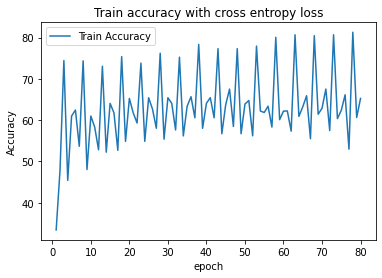

In [118]:
#plot train accuracy in each epoch
import matplotlib.pyplot as plt
%matplotlib inline
dim1 = []
dim1.extend(range(1, 81))
plt.plot(dim1,train_Acc_list,label='Train Accuracy')
plt.title('Train accuracy with cross entropy loss')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

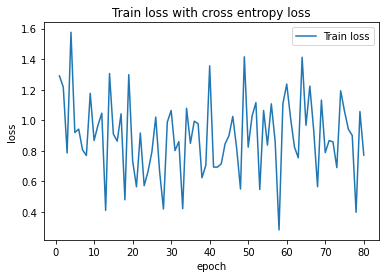

In [132]:
#plot train loss in each epoch
# import matplotlib.pyplot as plt
plt.plot(dim1,A1,label='Train loss')
plt.title('Train loss with cross entropy loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

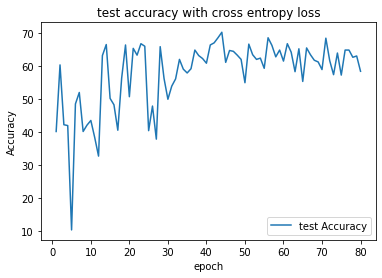

In [133]:
#plot test accuracy in each epochimport matplotlib.pyplot as plt
plt.plot(dim1,test_Acc_list,label='test Accuracy')
plt.title('test accuracy with cross entropy loss')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

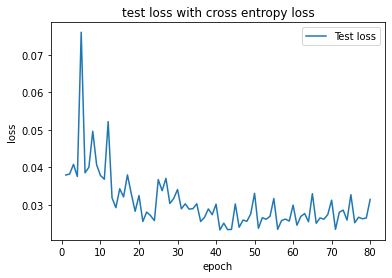

In [134]:
#plot test loss in each epochimport matplotlib.pyplot as plt
plt.plot(dim1,test_loss_list,label='Test loss')
plt.title('test loss with cross entropy loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()